In [1]:
import torch
import torch.nn as nn
from CircuitSimulation.CircuitSimulator import *
import numpy as np
from diffusers import UNet2DConditionModel
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, Dataset
from IPython.display import display, clear_output
from matplotlib.colors import ListedColormap
import hashlib
from itertools import combinations
from tqdm import tqdm
import random
from collections import defaultdict
import itertools
import os
import pickle

In [2]:
with open(os.path.join("output\\2025-05-07", "SquareLess3_training_data.pkl"), 'rb') as f:
    data = pickle.load(f)
mydict = data['trainingDict']

In [22]:
def tablePadding(truthTable):
    #Takes a truthtable and adds rows to fix row amount to 16.
    rows = truthTable.shape[0]

    padding = torch.full((16 - rows, truthTable.shape[1]), 2.0)
    return torch.cat((truthTable, padding), dim=0).long()

In [23]:
coloum1 = [0, 1, 0, 1]
coloum2 = [0, 0, 1, 1]

AND = [0,0,0,1]
OR = [0,1,1,1]
XOR = [0,1,1,0]
NAND = [1,1,1,0]
NOR = [1,0,0,0]
XNOR = [1,0,0,1]

In [24]:
# Inputs
col1 = torch.tensor([0, 1, 0, 1])
col2 = torch.tensor([0, 0, 1, 1])

# Gates
gates = {
    'AND':  torch.logical_and(col1, col2).int(),
    'OR':   torch.logical_or(col1, col2).int(),
    'XOR':  torch.logical_xor(col1, col2).int(),
    'NAND': (~torch.logical_and(col1, col2)).int(),
    'NOR':  (~torch.logical_or(col1, col2)).int(),
    'XNOR': (~torch.logical_xor(col1, col2)).int(),
}

input_indices = list(itertools.permutations(range(4), 2))
output_indices = list(range(4))

results = []
metadata = []  # <--- NEW: store metadata

for gate_name, gate_output in gates.items():
    for in1, in2 in input_indices:
        for out_idx in output_indices:
            inputs = torch.full((4, 4), 2)
            inputs[:, in1] = col1
            inputs[:, in2] = col2

            outputs = torch.full((4, 4), 2)
            outputs[:, out_idx] = gate_output

            full_table = torch.cat([inputs, outputs], dim=1)  # [4, 8]
            results.append(tablePadding(full_table))

            # Save the gate used, inputs used, and output column
            metadata.append({
                'gate': gate_name,
                'input_cols': (in1, in2),
                'output_col': out_idx
            })

# Stack results
final_tensor = torch.stack(results)  # Shape: [288, 4, 12]
print(final_tensor.shape)

torch.Size([288, 16, 8])


In [78]:
#metadata 
#results

In [25]:
numpyGates = final_tensor.numpy()
generated_bytes = [table.tobytes() for table in numpyGates]
len(generated_bytes)

288

In [80]:
# Step 2: Now compare each dataset item to the generated bytes
matches = []
for i, item_bytes in enumerate(mydict):
    if item_bytes in generated_bytes:
        match_idx = generated_bytes.index(item_bytes)
        matches.append((i, match_idx))  # (index in dataset, index in generated tables)

# Now `matches` contains tuples of matching indices
print("Matching entries:", matches)

Matching entries: [(0, 0), (1, 1), (2, 2), (3, 3), (4, 167), (5, 162), (6, 179), (10, 49), (11, 178), (12, 166), (15, 210), (20, 50), (27, 48), (32, 194), (33, 65), (35, 66), (61, 18), (80, 214), (120, 70), (165, 69), (213, 21), (311, 71), (334, 51), (425, 211), (438, 163), (458, 215), (463, 195), (481, 17), (519, 22), (566, 67), (753, 177), (796, 19), (1129, 199), (1230, 198), (1237, 203), (1264, 23), (1280, 151), (1353, 35), (1357, 64), (1359, 83), (1376, 68), (1411, 150), (1436, 53), (1480, 8), (1527, 193), (1535, 154), (1598, 153), (1652, 4), (1813, 227), (1821, 165), (1841, 226), (1895, 202), (1900, 16), (1913, 55), (1960, 52), (1962, 34), (2033, 145), (2054, 155), (2079, 82), (2205, 197), (2229, 176), (2332, 54), (2340, 7), (2497, 33), (2683, 6), (2715, 20), (2740, 81), (2797, 201), (2868, 58), (3412, 32), (3414, 5), (3438, 80), (3574, 213), (3761, 164), (3899, 209), (3937, 149), (3951, 225), (4015, 146), (4189, 192), (4256, 56), (4432, 152), (4516, 59), (4523, 9), (4567, 57), (4

In [ ]:
for j in matches:
    #print(j[1])
    matched_metadata = metadata[j[1]]
    print(matched_metadata, j)

{'gate': 'AND', 'input_cols': (0, 1), 'output_col': 0} (0, 0)
{'gate': 'AND', 'input_cols': (0, 1), 'output_col': 1} (1, 1)
{'gate': 'AND', 'input_cols': (0, 1), 'output_col': 2} (2, 2)
{'gate': 'AND', 'input_cols': (0, 1), 'output_col': 3} (3, 3)
{'gate': 'NAND', 'input_cols': (1, 3), 'output_col': 3} (4, 167)
{'gate': 'NAND', 'input_cols': (1, 2), 'output_col': 2} (5, 162)
{'gate': 'NAND', 'input_cols': (2, 3), 'output_col': 3} (6, 179)
{'gate': 'OR', 'input_cols': (0, 1), 'output_col': 1} (10, 49)
{'gate': 'NAND', 'input_cols': (2, 3), 'output_col': 2} (11, 178)
{'gate': 'NAND', 'input_cols': (1, 3), 'output_col': 2} (12, 166)
{'gate': 'NOR', 'input_cols': (1, 2), 'output_col': 2} (15, 210)
{'gate': 'OR', 'input_cols': (0, 1), 'output_col': 2} (20, 50)
{'gate': 'OR', 'input_cols': (0, 1), 'output_col': 0} (27, 48)
{'gate': 'NOR', 'input_cols': (0, 1), 'output_col': 2} (32, 194)
{'gate': 'OR', 'input_cols': (1, 2), 'output_col': 1} (33, 65)
{'gate': 'OR', 'input_cols': (1, 2), 'outpu

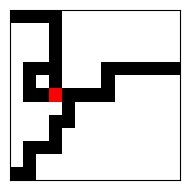

tensor([[0, 2, 2, 0, 2, 0, 2, 2],
        [1, 2, 2, 0, 2, 1, 2, 2],
        [0, 2, 2, 1, 2, 1, 2, 2],
        [1, 2, 2, 1, 2, 1, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2]])


In [132]:
#mydict
def printCircuit(circuit):
    cmap = ListedColormap(['white', 'black', 'red', 'blue'])
    fig, ax = plt.subplots(figsize=(2, 2))

    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(circuit, cmap=cmap, interpolation='nearest', vmin=0, vmax=3)
    plt.tight_layout()
    plt.show()


testID = 57
probabilityCircuit = mydict[generated_bytes[testID]][0]
argmaxCircuit = torch.argmax(probabilityCircuit, dim=0, keepdim=False).cpu().numpy()

printCircuit(argmaxCircuit)
print(final_tensor[testID])

In [103]:
288/6

48.0

There should only be 24 differnet ways to make the gate truthtables. The remaining 48-24 are probably because the permuation code considers order important. The matched pairs are still correct, so it doesn't matter too much that the number of tables is inflated. Just the real number is half, 288/2=144.

In [26]:
def count2inpLogicGates(trainingDict):
    matches = []
    for i, item_bytes in enumerate(trainingDict):
        if item_bytes in generated_bytes:
            match_idx = generated_bytes.index(item_bytes)
            matches.append((i, match_idx))  # (index in dataset, index in generated tables)

    gateCount = {}
    for j in matches:
        matched_metadata = metadata[j[1]]
        gateCount[matched_metadata['gate']] = gateCount.get(matched_metadata['gate'], 0) + 1
    
    return gateCount

In [36]:
def getGateRepresentation(dict):
    torch.set_printoptions(precision=2, sci_mode=False)
    andGates = torch.zeros((13,13))
    nandGates = torch.zeros((13,13))

    for _, (circuit, _) in dict.items():
        andGates += circuit[2]
        nandGates += circuit[3]
        
    andGates = (andGates != 0).sum().item()
    nandGates = (nandGates != 0).sum().item()
    
    return andGates, nandGates

In [37]:
with open(os.path.join("output\\2025-05-07", "SquareLess3_training_data.pkl"), 'rb') as f:
    data = pickle.load(f)
print(count2inpLogicGates(data['trainingDict']))
print(getGateRepresentation(data['trainingDict']))

{'AND': 24, 'NAND': 23, 'OR': 24, 'NOR': 20}
(81, 26)


In [38]:
with open(os.path.join("output\\2025-05-07", "SquareLess2_training_data.pkl"), 'rb') as f:
    data = pickle.load(f)
print(count2inpLogicGates(data['trainingDict']))
print(getGateRepresentation(data['trainingDict']))

{'AND': 24, 'OR': 24, 'NAND': 24, 'NOR': 24}
(36, 58)


In [39]:
with open(os.path.join("output\\2025-05-12", "SquareLessLongerv2_training_data.pkl"), 'rb') as f:
    data = pickle.load(f)
print(count2inpLogicGates(data['trainingDict']))
print(getGateRepresentation(data['trainingDict']))

{'AND': 24, 'NAND': 24, 'OR': 24, 'NOR': 24}
(143, 143)


In [40]:
with open(os.path.join("output\\2025-05-13", "HigherInference_training_data.pkl"), 'rb') as f:
    data = pickle.load(f)
print(count2inpLogicGates(data['trainingDict']))
print(getGateRepresentation(data['trainingDict']))

{'AND': 14, 'NOR': 18, 'OR': 18, 'NAND': 17}
(42, 42)


In [41]:
with open(os.path.join("output\\2025-05-15", "HigherInference_training_data2.pkl"), 'rb') as f:
    data = pickle.load(f)
print(count2inpLogicGates(data['trainingDict']))
print(getGateRepresentation(data['trainingDict']))

{'AND': 8, 'NOR': 21, 'NAND': 17, 'OR': 16}
(70, 94)
